In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme as gev
from scipy.stats import invweibull
from scipy.stats import weibull_min

from unseen import fileio
from unseen import stability
from unseen import indices

In [3]:
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"

model_files = {
    'CAFE': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CAFE-c5-d60-pX-f6_19950501-20201101_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'CanESM5': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'CMCC-CM2-SR5': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CMCC-CM2-SR5-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'EC-Earth3': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_EC-Earth3-dcppA-hindcast_196011-201711_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'HadGEM3-GC31-MM': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'IPSL-CM6A-LR': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'MIROC6': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'MPI-ESM1-2-HR': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MPI-ESM1-2-HR-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
    'MRI-ESM2-0': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MRI-ESM2-0-dcppA-hindcast_196011-201911_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
#    'NorCPM1': "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_NorCPM1-dcppA-hindcast_196010-201810_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip",
}

# NorCPM1 fails the similarity test

In [4]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [5]:
agcd_max = agcd_ds['pr'].values.max()
print(agcd_max)

410.43057


In [31]:
def create_plot(dist):
    """Create plot using gev or weibull_min distribution"""
    
    if dist == 'gev':
        pdf_func = gev.pdf
        user_estimates = []
    elif dist == 'weibull_min':
        pdf_func = weibull_min.pdf
        user_estimates = [50, 135]
    
    fig = plt.figure(figsize=[7, 12])
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    # Plot models
    gev_xvals = np.arange(0, 700)
    for model_name, model_file in model_files.items():
        model_ds = fileio.open_dataset(model_file)
        model_da = model_ds['pr'].dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

        model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(
            model_da.values,
            distribution=dist,
            user_estimates=user_estimates,
        )
        model_gev_pdf = pdf_func(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
        ax1.plot(gev_xvals, model_gev_pdf, label=model_name)
        
        model_return_periods, model_return_values = stability.return_curve(
            model_da,
            dist,
            params=[model_gev_shape, model_gev_loc, model_gev_scale],
        )
        ax2.plot(model_return_periods, model_return_values, label=model_name)

    # Plot obs GEV (with record event)
    agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(
        agcd_ds['pr'].values,
        distribution=dist,
        user_estimates=user_estimates,
    )
    agcd_gev_pdf = pdf_func(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    ax1.plot(gev_xvals, agcd_gev_pdf, color='black', linewidth=2.0, label='AGCD')

    agcd_return_periods, agcd_return_values = stability.return_curve(
        agcd_ds['pr'],
        dist,
        params=[agcd_gev_shape, agcd_gev_loc, agcd_gev_scale]
    )
    ax2.plot(agcd_return_periods, agcd_return_values, label='AGCD', color='black', linewidth=2.0)

    # Plot obs GEV (without record event)
    agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(
        agcd_ds['pr'].values[:-1],
        distribution=dist,
        user_estimates=user_estimates,
    )
    agcd_gev_pdf = pdf_func(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    ax1.plot(gev_xvals, agcd_gev_pdf, color='black', linewidth=2.0, label='AGCD (no record)', linestyle='--')

    agcd_return_periods, agcd_return_values = stability.return_curve(
        agcd_ds['pr'],
        dist,
        params=[agcd_gev_shape, agcd_gev_loc, agcd_gev_scale],
    )
    ax2.plot(agcd_return_periods, agcd_return_values, label='AGCD (no record)', color='black', linewidth=2.0, linestyle='--')
    
    ax1.grid()
    ax1.set_xlabel('Rx15day (mm)')
    ax1.set_ylabel('probability')
    ax1.axvline(agcd_max, color='0.5', linestyle='--')
    ax1.set_title('(a) GEV fit to (multiplicative) bias corrected data')
    ax1.set_xlim([0, 450])
    ax1.legend()

    ax2.legend()
    ax2.axhline(agcd_max, color='0.5', linestyle='--')
    ax2.set_xscale('log')
    ax2.set_xlabel('return period (years)')
    ax2.set_ylabel('Rx15day (mm)')
    ax2.set_title('(b) Return periods corresponding to GEV fits')
    ax2.set_ylim([0, 700])
    ax2.grid()

    if dist == 'gev':
        outfile = '/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_gev-pdf-and-return-curves_ensemble.png'
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=400)
        print(outfile)
    else:
        plt.show()

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_gev-pdf-and-return-curves_ensemble.png


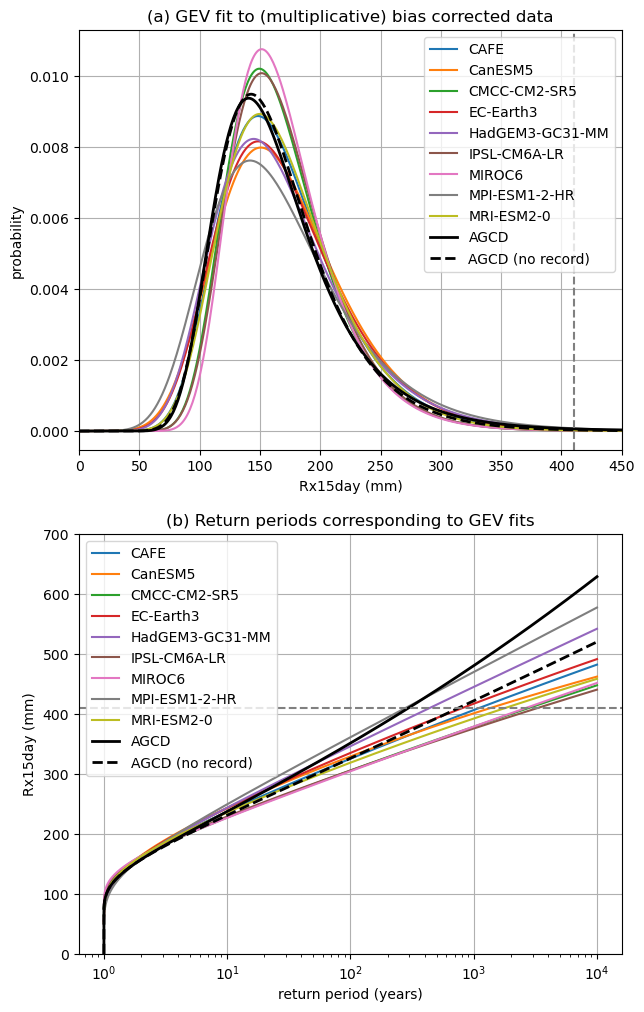

In [32]:
create_plot('gev')

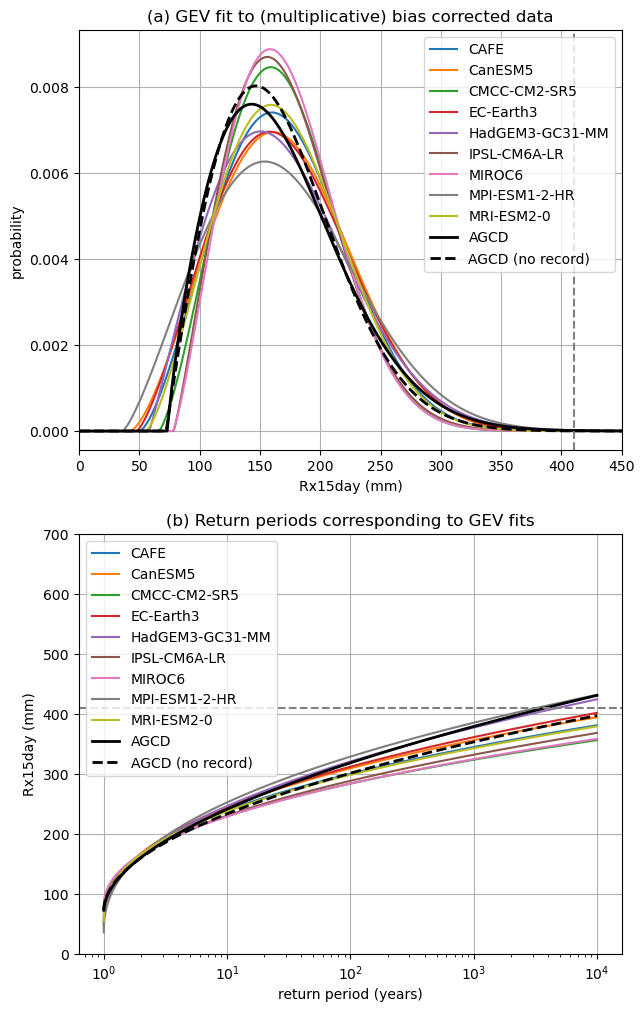

In [29]:
create_plot('weibull_min')

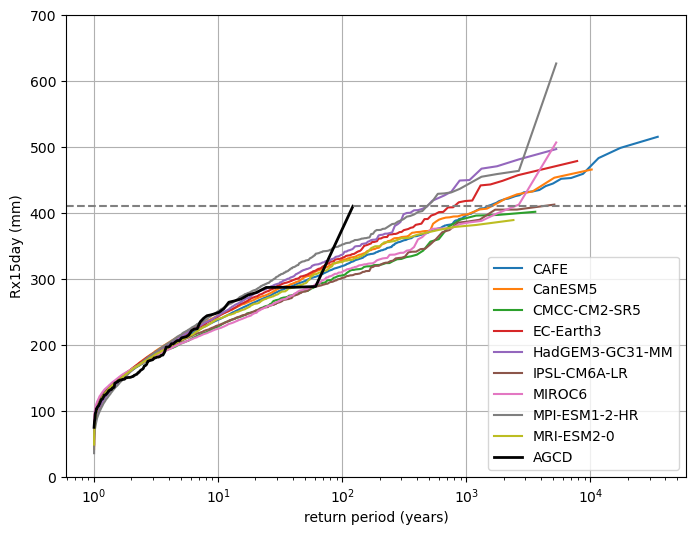

In [30]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

# Plot models
for model_name, model_file in model_files.items():
    model_ds = fileio.open_dataset(model_file)
    model_da = model_ds['pr'].dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})
    model_return_periods, model_return_values = stability.return_curve(model_da, 'empirical')
    ax.plot(model_return_periods, model_return_values, label=model_name)

# Plot obs
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')
agcd_return_periods, agcd_return_values = stability.return_curve(agcd_ds['pr'], 'empirical')
ax.plot(agcd_return_periods, agcd_return_values, label='AGCD', color='black', linewidth=2.0)
    
ax.legend()
ax.axhline(agcd_max, color='0.5', linestyle='--')
ax.set_xscale('log')
ax.set_xlabel('return period (years)')
ax.set_ylabel('Rx15day (mm)')
ax.set_ylim([0, 700])
ax.grid()

#plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
#print(outfile)
plt.show()